# Stock Prediction

We are using historical data from yahoo's finance api's to predict the stock prick for a given stock symbol, given other stock symbols. In addition to the normal pandas and numpy libraries, We are also using Prophet (https://facebook.github.io/prophet/docs/quick_start.html), which is a forecasting library released by the Facebook core datascience team. It implements a procedure for forecasting trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.


In [1]:
!conda install -c conda-forge fbprophet -y
!pip install --upgrade plotly
!pip install yfinance



import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.

KeyboardInterrupt: 

    Now we load the data. We can specify the start and end dates and also the stock symbol.

In [10]:
import pandas_datareader.data as web
import datetime
import numpy as np
import yfinance as yf

# change this to your desired stock symbol to get results
stockSymbol = 'SBIN.NS'
# Considering data from 2000 to 2022
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2022, 1, 21)

# we now get data for that stock symbol from yahoo finance api
df = yf.download( stockSymbol, start , end)
print(df.head())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  227.500000  230.000000  227.500000  229.119995  202.633820   
2010-01-05  230.800003  231.000000  228.009995  229.205002  202.708954   
2010-01-06  229.699997  231.500000  228.500000  230.580002  203.925018   
2010-01-07  230.600006  231.000000  228.110001  229.289993  202.784119   
2010-01-08  229.399994  230.389999  228.009995  228.604996  202.178345   

              Volume  
Date                  
2010-01-04  11031470  
2010-01-05  11613740  
2010-01-06  14527930  
2010-01-07   8576510  
2010-01-08  10453820  


In [11]:
# Now we can get an array of only the closing values and plot the data
close = df['Close']

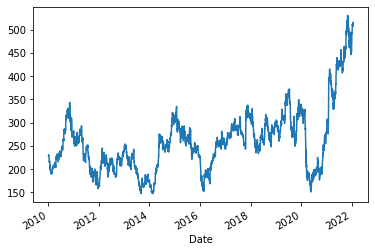

In [12]:
#Plotting the data
close.plot();

In [13]:
# We now reformat the data frame to have columns 'ds' and 'y' with the dates and values respectively which is needed
# by prophet. We also take the log of the values to get more managable values
close_df = close.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
close_df['y'] = np.log(close_df['y'])

In [14]:
# Now we create the prophet model with daily seasonality to be true
model = Prophet(daily_seasonality=True)
model.fit(close_df)
# 5* 365 = 1825.Forecasting for 5 years from now. 
future = model.make_future_dataframe(periods=1825) 
forecast = model.predict(future)
print(forecast)

NameError: name 'Prophet' is not defined

In [15]:
model.plot(forecast)

NameError: name 'model' is not defined

# We can now do a performance evaluation of the result obtained from this.

In [45]:
# to do an evaluation, we join the dataframe df with the forecast obtained. We transform it by dropping na and just taking 
# the yhat, upper, lower and close values.
data = forecast.set_index('ds').join(df)
data = data[['Close', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(500)
data['yhat']=np.exp(data.yhat)
data['yhat_upper']=np.exp(data.yhat_upper)
data['yhat_lower']=np.exp(data.yhat_lower)

In [46]:
data

,Close,yhat,yhat_upper,yhat_lower
ds,,,,
2017-01-06,131.070007,114.679300,131.835107,96.492251
2017-01-09,130.949997,116.685963,135.865336,100.714747
2017-01-10,129.889999,117.579759,138.037388,101.708998
2017-01-11,130.500000,118.167084,137.682220,99.769448
2017-01-12,129.179993,119.477904,140.489861,101.755617
2017-01-13,133.699997,120.119127,142.636646,101.624446
2017-01-17,132.889999,124.369699,144.984335,107.347574
2017-01-18,133.259995,125.279105,145.795228,107.011256
2017-01-19,138.410004,126.944769,148.426539,108.468855


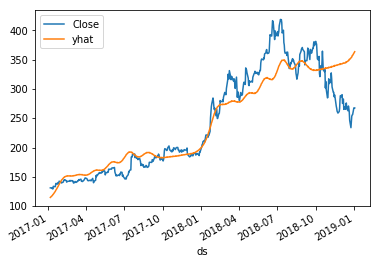

In [47]:
# we can now plot the actual values with predicted ones
data[['Close', 'yhat']].plot()


# Average errors is as below

In [48]:
AE = (data.yhat - data.Close)
print(AE.describe())

count    500.000000
mean      -1.255792
std       31.812232
min     -100.616987
25%      -16.470317
50%        1.334983
75%       10.789524
max      119.173990
dtype: float64


# The R2 score , Mean squared error and Mean absolute error is asbelow

In [49]:
r2_score(data.Close, data.yhat)


0.8613139983370754

In [50]:
mean_squared_error(data.Close, data.yhat)

1011.5710595526581

In [51]:
mean_absolute_error(data.Close, data.yhat)

22.395376137336456

# Forecasting with y upper and y lower confidence

Text(0.5, 0, 'Date')

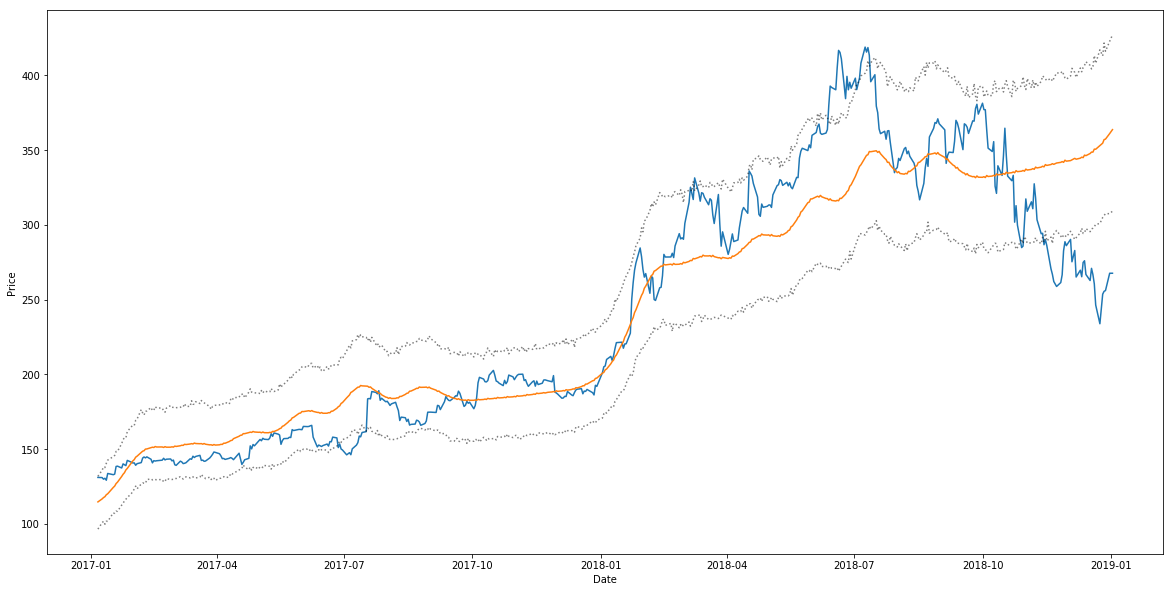

In [52]:
plt.rcParams['figure.figsize']=(20,10)
fig, ax1 = plt.subplots()
ax1.plot(data.Close)
ax1.plot(data.yhat)
ax1.plot(data.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax1.plot(data.yhat_lower, color='black',  linestyle=':', alpha=0.5)
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

In [9]:
import pickle

# read the Prophet model object
with open('./../../resources/fbprophet/model/AARTIIND.NS.pkl', 'rb') as f:
    m = pickle.load(f)

selected_stock = 'SBIN.NS'

In [11]:
with open('./../../resources/fbprophet/model/'+ selected_stock+'.pkl', 'rb') as f:
    m = pickle.load(f)
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2980,2022-01-26,7.375998,7.276975,7.448330,7.375998,7.375998,-0.014106,-0.014106,-0.014106,0.006647,...,-0.019100,-0.019100,-0.019100,-0.001653,-0.001653,-0.001653,0.0,0.0,0.0,7.361892
2981,2022-01-27,7.376445,7.280961,7.451429,7.376445,7.376445,-0.012680,-0.012680,-0.012680,0.006647,...,-0.016905,-0.016905,-0.016905,-0.002423,-0.002423,-0.002423,0.0,0.0,0.0,7.363765
2982,2022-01-28,7.376893,7.275881,7.446600,7.376893,7.376893,-0.013153,-0.013153,-0.013153,0.006647,...,-0.016674,-0.016674,-0.016674,-0.003126,-0.003126,-0.003126,0.0,0.0,0.0,7.363740
2983,2022-01-29,7.377340,7.312842,7.470937,7.377340,7.377340,0.017263,0.017263,0.017263,0.006647,...,0.014368,0.014368,0.014368,-0.003752,-0.003752,-0.003752,0.0,0.0,0.0,7.394603
2984,2022-01-30,7.377787,7.375164,7.540358,7.377787,7.377787,0.078851,0.078851,0.078851,0.006647,...,0.076495,0.076495,0.076495,-0.004291,-0.004291,-0.004291,0.0,0.0,0.0,7.456639


In [8]:
Step 1: Uninstall pystan

pip uninstall pystan
Step 2: Install pystan version ~2.14

pip install pystan~=2.14
**Step 3: Try installing fbprophet again **

pip install fbprophet



  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  ERROR: Command errored out with exit status 1:
   command: /Users/arungupta/opt/anaconda3/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/xm/04s2ld0n1jqbwfgytc7tjrf00000gn/T/pip-install-f8e9b71w/fbprophet_56f7b4e365de46ae9516b4eddb62dc43/setup.py'"'"'; __file__='"'"'/private/var/folders/xm/04s2ld0n1jqbwfgytc7tjrf00000gn/T/pip-install-f8e9b71w/fbprophet_56f7b4e365de46ae9516b4eddb62dc43/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/xm/04s2ld0n1jqbwfgytc7tjrf00000gn/T/pip-wheel-idz4gh84
       cwd: /private/var/folders/xm/04s2ld0n1jqbwfgytc7tjrf00000gn/T/pip-install-f8e9b71w/fbprophet_56f7b4e365de46ae9516b4eddb62dc43/
  Complete out

In [ ]:
import datetime

import yfinance as yf

import pandas as pd
import numpy as np
from fbprophet import Prophet
from pathlib import Path
import pickle


# Considering data from 2000 to 2022
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2022, 1, 22)

stocks = Path('./../../resources/stock_list.txt').read_text().split("\n")
index=1
for s in stocks:
    print(s)
    df = yf.download( s, start , end)
    close = df['Close']

    close_df = close.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
    close_df['y'] = np.log(close_df['y'])
    model = Prophet(daily_seasonality=True)
    model.fit(close_df)
    pkl_path = "./../../resources/fbprophet/model/"+s+".model"
    with open(pkl_path, "wb") as f:
        pickle.dump(model, f)

#     # save the dataframe
#     forecast.to_pickle("./../../resources/fbprophet/forecast/"+s+".forecast")
    print(index,"*** Data Saved for -> ",s)
    index = index+1



AARTIIND.NS
[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.26417
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4309.07    0.00256795        833.28       1.194      0.1194      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4348.94    0.00891147       4730.98           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4363.97    0.00418525       655.108           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4377.63    0.00080378       3408.54      0.1105           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4387.04    0.00143243       910.393           1        

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.55247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4358.67    0.00569616       2770.87           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4442.77    0.00349235       3669.13      0.1881      0.1881      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4529.39   0.000544328       981.867           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4564.24   0.000332754        5967.5      0.3674      0.3674      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4584.58     0.0116355        8565.8           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -5.26951
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3379.08     0.0174996       2281.35           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3575.6     0.0161711       1352.65           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3689.45     0.0293655       8776.96      0.1871           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3813.25     0.0115337        1689.1           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3824.92   0.000274119       169.124           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.12063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4028.44     0.0034135       5288.27      0.1381           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4119.74    0.00305652       2602.12       0.259      0.6106      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4188.02    0.00945464       2043.39           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4223.53    0.00248233       3536.35      0.3857           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4260.9    0.00561828       1309.02           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.60802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3657.46     0.0242628       9900.72           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3720.55    0.00492042        3695.7      0.5707      0.5707      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3809.47    0.00894972        4958.2           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3836.47    0.00508991       1456.85           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3854.47   0.000770064       505.227      0.2358      0.5897      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.37133
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4683.12    0.00351273       2318.71           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4794.83    0.00844279       12075.1           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4857.33   0.000434881       3176.56           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4895.32    0.00250723       12437.9      0.3187      0.3187      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4910.19    0.00402273        1342.4           1           1      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.46867
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4083.52     0.0189719       1684.85           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4215.55     0.0274521       8241.05           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4264.53    0.00478614       2463.72           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4304.62    0.00619423       1049.87           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4326.37    0.00173548       1060.91           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.93558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99       4450.13   0.000473783       2755.42      0.2081           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4502.64   0.000474442       1676.78      0.2067           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4521.12   0.000936396       873.279           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          4537    0.00236396

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -4.21727
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3655.65     0.0024209       851.856           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3738.89     0.0157377        1746.8           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3811.85    0.00279464       1247.34           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3846.61    0.00125244       743.407           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3862.05   0.000520519       355.118           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.1195
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4595.59     0.0127726       11849.7           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4664.12   0.000633004       1805.03           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        4769.8   0.000713918       1582.94           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4810.87    0.00132888        2048.1           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4847.31   0.000217925       2126.84           1           1      578

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.71415
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3554.1    0.00321742       456.145      0.9047      0.9047      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3620.85    0.00505467       5951.86      0.4136      0.4136      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3721.24     0.0099971       1616.08           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3746.26    0.00203225          2138           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3764.41    0.00877195       2193.62           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.47703
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3879.54    0.00215485       1330.22      0.7149      0.7149      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3975.12     0.0172922       8795.52           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4061.32    0.00188784       672.892           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4120.54    0.00151443       771.069           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4129.5   0.000686668       1559.71      0.6408      0.6408      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.20953
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4409.99    0.00466368       3749.85           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4559.23     0.0025435       7552.14           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4694.28    0.00042844        2935.8           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4777.05    0.00198944       6035.66           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4819.22    0.00202515        3033.3           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.27581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3919.25     0.0174705       3715.65           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4020.99    0.00411034       1514.65           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4088.55    0.00808346       3121.12           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4134.77    0.00533347       11691.7      0.6286      0.6286      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4174.9    0.00318049       3553.26           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.45852
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4004.57      0.025991       3452.15           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4098.5    0.00241587       2585.29           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4234.15     0.0274801       3431.79           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4259.98    0.00028313       1453.18           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4298.84    0.00107452       1710.53     0.06209           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.37272
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3998.33    0.00551891       5502.34           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4104.29   0.000398226       1239.28           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4179.79     0.0159861       4910.29           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4232.7    0.00365834       2882.95           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4256.79    0.00233815       1673.66           1           1      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.57428
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3213.78    0.00509403        1288.2           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3312.82     0.0430987        1874.4           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3341.15   0.000683668        1055.3           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3348.67    0.00537092        962.58           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424       3358.94   3.90437e-05       642.678   5.605e-08       0.001      52

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.28645
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4286.34    0.00142009       2783.38           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4343.63    0.00817093       2316.47           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4415.81    0.00978098       3342.73           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4474.31     0.0044496       1128.99           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4499.66    0.00386071       2113.96        1.41       0.141      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -8.18576
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3658.91    0.00958518       5014.73      0.4726           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3696.57    0.00699081       635.038           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3757.29     0.0145786       2159.15           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3777.14   0.000255021       1408.17     0.05008      0.8445      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3798.38    0.00975054       1984.92           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.54109
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3711.89    0.00250921       761.527           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3845.61      0.127613       7448.17           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3958.22    0.00721714       1342.16           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3989.3    0.00150097       2650.53      0.1727           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4006.19    0.00059487       2065.66      0.2122      0.9432      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -7.18558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3031.78    0.00574276       537.323           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3114.59    0.00256304       660.816      0.6187      0.6187      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3200.16    0.00539948       1545.38      0.2949           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3219.5    0.00419043       483.839           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3245.69    0.00205121       248.122      0.8797      0.8797      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.27205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4441.51   0.000273898        913.25      0.4201      0.4201      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4523.34    0.00324509       4446.61           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4677.72      0.105401       29549.7           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4729.79    0.00103648        2416.3           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4754.59   0.000555263       1812.84      0.9249      0.9249      55

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.11811
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4472.85    0.00108658       7454.44      0.8434      0.8434      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4611.4    0.00166095       4721.47           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4716.73   0.000555488       1258.68      0.9132      0.9132      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4761.74    0.00465211       7708.22           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4805.38    0.00303589       1637.09      0.7495      0.7495      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.15744
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3964.51    0.00300633       3131.27           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4163.24    0.00578173        3018.4           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4209.51    0.00121022       1332.37           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4294.78     0.0271054       4222.34           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4341.38    0.00115458       898.277      0.6542      0.6542      59

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.47039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3806.61   0.000728006       782.504           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3862.47   0.000664632       1030.16           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3892.24    0.00278937       1352.51           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3928.16     0.0249772       2499.89      0.4898           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3944.54   0.000389237       294.153           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -5.97292
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3512.36   0.000898411       389.255       0.678       0.678      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3597.46     0.0122553       751.197           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3674.44    0.00129162       1756.08           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3699.79    0.00197733       1775.75           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3716.51    0.00633305       2614.82           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.57951
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4410.99     0.0107473       3616.69           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4442.32    0.00752804       4876.92           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4580.17     0.0100793       10329.7           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4643.89     0.0160196       14535.9      0.5491      0.5491      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4658.39    0.00121917       4443.65           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.67877
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3743.52    0.00489682       4828.56           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3865.06     0.0243208       8249.49           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3964.99    0.00746309        3333.5      0.1666      0.9455      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4020.29   0.000739823       874.488           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4048.21   0.000651816       1447.54      0.5869      0.5869      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.36379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4052.35    0.00657337       3167.68           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4158.59    0.00649403        7129.9           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        4292.3     0.0153435       5414.11           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4322.69   0.000287571       2724.94      0.3808      0.3808      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4337.72       0.00194       1388.34           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.12529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4317.27    0.00274855       6548.62           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4528.11    0.00696167       10543.5      0.7608      0.7608      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4690.51    0.00173535       1981.66           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4740.41   0.000201255       6318.97      0.8457      0.8457      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4787.94    0.00178199       2702.34           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.57741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3832.83     0.0028877       2753.04      0.1542           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3972.44     0.0104711       3204.79      0.2763      0.2763      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4107.94    0.00315414       1645.59           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4150.48    0.00258168       1937.41           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4170.07   0.000737456       1225.92       0.855       0.855      54

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.69196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4167.42     0.0116708       11571.7       0.543      0.0543      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4264.32    0.00253722       1421.61      0.4701           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        4342.7     0.0329679         14467           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4463.46   0.000210158       772.725           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4486.71    0.00353205       3285.52           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.92025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4137.47     0.0302109       2436.89           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4204.98    0.00924389       1429.04      0.9971      0.9971      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4242.05     0.0192417       5180.17           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4295.91   0.000830371       1071.25           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4303.6    0.00344883       3640.88      0.1161           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.87253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4001.58    0.00506444       2604.72           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4115.31    0.00193902       3612.68      0.6438      0.6438      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4172.79    0.00370403       2494.78      0.3263           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4220.29    0.00879155        7967.6      0.6205      0.6205      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4265.8   0.000274614        1387.2      0.8459      0.8459      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.10166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4585.39     0.0046192       3369.95           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4616.32   0.000953428       2038.25           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4665.27   0.000505123          2601           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4696.52    0.00555362        2841.6           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4710.85   0.000361287       1582.55           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.3711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3064.44    0.00186116       1563.61           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3212.33    0.00421223       3135.15           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3261.79    0.00380882       2558.03           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3286.11    0.00256256       2438.66           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3313.74    0.00732816       1642.73           1           1      571

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -7.37957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3313.09    0.00826281       3151.41      0.1331           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3412.47    0.00207889        739.13           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3442.93    0.00867047       2808.87      0.2075           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3508.9    0.00466981       667.205           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3529.36     0.0065606       419.592           1           1      60

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.17759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4459.89    0.00197151        6908.4           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4577.39    0.00380379       5500.83      0.3928      0.3928      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4664.08   0.000814262       2267.18           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4698.3    0.00153326       2759.16      0.4973           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4734.81    0.00257229       2954.08           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -5.95446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4121.56    0.00827065       3505.94           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4215.17    0.00265826       2422.55           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4269.92   0.000354273       853.001           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4302.66    0.00143884       1124.01           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4397.06   0.000717593       560.599           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -5.16492
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3628.38     0.0100698       1375.09           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3677.53   0.000811894       800.511           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3708.74    0.00469328       1404.94           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3768.28    0.00233294       1006.93           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3778.87     0.0140203       3566.59      0.3769           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.24197
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4367.34    0.00250404       2856.25       2.923      0.2923      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4480.64     0.0129227       3715.24           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4620.06    0.00060064       4530.32           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4657.93   0.000508665       2136.08           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4670.16   0.000681327       1538.12           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.69325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4055.1    0.00443677       2000.29           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4200.66    0.00209626       4338.65           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4264.73    0.00453097       5202.88      0.5712      0.5712      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4452.54    0.00159445       1484.05           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4483.13   0.000280205          2739           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.24514
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3825.03    0.00417466       2213.33           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3991.12    0.00468215       3858.86           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4054.71     0.0115756       1253.42           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4073.04      0.055984       8462.75           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4105.8    0.00213151       783.168           1           1      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.32419
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4082.51      0.102869         38084           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4245.55   0.000115155       394.217           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4291.23    0.00473538       2162.35           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4320.34     0.0239941       3855.42           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4334.05    0.00132007       544.123           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -4.52393
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3339.88     0.0147398       2842.28           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3415.05    0.00721875       1895.32      0.5721      0.5721      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3502.36   0.000644453       502.716           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3513.68    0.00100676       189.736      0.8749      0.8749      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3528.09     0.0180254       2043.21           1           1      59

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.85567
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3818.64    0.00233142       1609.27           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3946.14     0.0253375       18355.7      0.2994           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4017.77    0.00162651       2331.14           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4052.66    0.00215084       971.672           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4093.87    0.00209608       1056.57      0.4615      0.4615      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -7.46855
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3346.03    0.00113153       1466.63      0.3659      0.3659      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3387.4      0.002282       524.225      0.7981      0.7981      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3410.25    0.00145134       981.811     0.03345           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3429.6    0.00183642       243.811           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3439.5   0.000366046        523.05      0.8892      0.8892      60

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.50734
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3829.93   0.000873516       1846.99           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3873.96     0.0105417       2294.43           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3901.4    0.00227389       846.601      0.8354      0.8354      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3920.29     0.0046876       1216.98           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3932.9     0.0436932       4084.94       3.988      0.3988      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -4.3929
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3632.22     0.0313345       14203.9           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3735.56    0.00446885        1291.5           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3787.81    0.00172436       1250.65           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3863.6    0.00466923       1076.24           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3945.17     0.0146769       1619.31      0.4438           1      571

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -4.32387
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4106.19    0.00308873       5044.63           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4181.01     0.0171364       3260.78           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        4223.8     0.0134376       2385.79           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4393.39    0.00685559       4092.22        0.84        0.84      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4416.84    0.00266347       1666.17           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.57837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3969.22      0.016766       5925.92      0.2997           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4093.2    0.00272194       2051.63           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4189.64     0.0168811       5441.34           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4234.34    0.00336729       2214.54           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4273.12     0.0032087       1129.86      0.1236           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.45804
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4309.45    0.00225246       3638.58           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4349.43   0.000226431       1463.01           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4416.38     0.0249352       4025.03      0.9859      0.9859      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4468.9    0.00419072       5064.59           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4491.21   0.000919012       908.924           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.29155
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4344.57   0.000840732       2288.42           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4485.98    0.00130124        2329.3      0.2607           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4526.54   0.000235996       1614.52           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4560.71    0.00901973       6364.43           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4619.85    0.00615751       5264.01           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.44107
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3630.24    0.00228075       3459.18           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3751.44   0.000180889       461.155      0.8065      0.8065      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3792.96    0.00147644        2009.5      0.6645      0.6645      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3836.33    0.00202233       4239.15           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3849.68    0.00648099       1174.56           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.24741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4199.56    0.00426604       1639.98           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4370.04     0.0067973       2599.52           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4418.79    0.00509276       5102.78       2.541      0.2541      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4496.41     0.0015074       2537.54           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4521.36    0.00226532       1484.47           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.12353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4452.56     0.0131075       12286.4           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4551.7    0.00321915       1827.38           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4586.86    0.00507737       7178.79      0.2958           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4677.46    0.00914088       5483.52           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4715.16    0.00389691       1694.83      0.8549      0.8549      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.31439
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4417.5    0.00143331       6259.54      0.3662           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4590.44    0.00131147       6328.58      0.4723      0.4723      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4690.89     0.0582955       2704.78           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4724.8    0.00349234       3424.63           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4737.1   0.000689215       1503.99           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -5.93037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3656.47     0.0292113       4400.87           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3759.18    0.00588465       2356.01           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3830.21     0.0321837       5893.46           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3885.01    0.00059716       1080.77      0.7133      0.7133      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3905.26   0.000404467        1681.1           1           1      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.88041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          3512    0.00190307       1448.21      0.8804      0.8804      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3586.83     0.0479412       3952.76           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3694.14    0.00219395       1178.94           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3716.73     0.0106959       770.415           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3755.89    0.00630277       1893.58           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.94422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3884.31    0.00418663       14357.4      0.1506           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3957.73   0.000685373       4883.02      0.1834      0.1834      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4009.21     0.0341624       1904.14           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4034.3    0.00270875       549.477      0.4258           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4044.43     0.0005452       315.363      0.9852      0.9852      59

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.50261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4102.18    0.00243625       4090.73       0.554       0.554      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4201.85     0.0214182        3537.8           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4254.76    0.00428408       9587.24      0.2364           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4282.76   0.000130088       3325.12      0.2977      0.2977      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4335.35    0.00197372       1819.56       1.148      0.1148      59

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.32568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3999.37     0.0058472       1856.67           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4057.17     0.0142979       4390.74           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4191.81   0.000492879       3894.79      0.2899      0.2899      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4215.21    0.00220748       687.545           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4244.09   0.000930018       698.461           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -4.92179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3116.15    0.00275897       429.278           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3198.1     0.0142548       1153.61           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3281.16    0.00502299       2047.78      0.6894      0.6894      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3331.98     0.0311952       3307.19           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3356.92       0.02098        1019.4      0.7931     0.07931      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.75793
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2780.84     0.0032967       2731.41           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2842.42     0.0111356          4622           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2904.6     0.0118535       1162.13           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2924.35     0.0126408       1586.38           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2935.47   0.000215603       487.012           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -7.46124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3812.69    0.00321333       949.061           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3841.03    0.00469735       914.283           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3880.4   0.000445365       215.223           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3892.35     0.0053536       2030.66           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3910.98   0.000148705       805.076      0.5914      0.5914      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.27994
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2215.58    0.00338241       715.013           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2253.28   0.000642376       624.086           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2266.7    0.00821698       1382.21       2.982      0.2982      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2273.21    0.00170293       295.784           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2276.08    0.00273684       1030.36           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.53348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4111.6   0.000703374       891.915           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4167.38    0.00163607        2880.1           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4212.56    0.00275781       905.023           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4263.22    0.00669492       3428.31      0.3075           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4294.12    0.00459412       2444.21           1           1      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.91875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3782.93    0.00605517       1325.12           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3809.6   0.000318826       836.252      0.4302      0.4302      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3819.18   0.000719535       1286.09       0.368           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3857.83    0.00230749        2077.3           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3876.84    0.00183767       479.932           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.25966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4281.75    0.00615432       2248.16           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4345.63   0.000803045       1497.85           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4473.37    0.00450958       5162.11       1.735      0.1735      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4501.16    0.00325794       7695.27      0.9588      0.9588      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4520.28   0.000280457       1010.97      0.8356      0.8356      59

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.49632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3993.55    0.00879686       5305.82           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4105.4   0.000511906       1634.72           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4197.18      0.012084       4097.81           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4238.39   0.000422888       1280.94      0.2337      0.2337      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4272.28    0.00189149       1628.28           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.35266
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4350.42     0.0115789       5771.14           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4441.93    0.00791155       5852.56           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4530.76    0.00335111       2295.61           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4573.74   0.000339314       974.711           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4597.82   0.000807522       780.622           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -5.34118
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3189.85     0.0261011       2335.47           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3263.42    0.00559142       1712.11           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3384.53     0.0198029        1460.5      0.9529     0.09529      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3423.25     0.0154581       771.635        1.71       0.171      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3456.38     0.0112746       1287.07           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.95941
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3584.09      0.041097       1611.97           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3725.26    0.00471091       2075.83           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3916.4    0.00562065       6174.71      0.1228           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3994.37    0.00271948       1099.46           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4007.95    0.00352362       1079.96           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.19664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4156.15    0.00900323       7008.68           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4324.72   0.000967203       4103.75      0.3515      0.3515      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4377.05    0.00116899       1593.66           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4404.31    0.00271881       1773.29           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4453.96    0.00829728       4170.31           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.1609
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4244.49    0.00104855       4856.48           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4396.78    0.00472301       4801.63           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4491.42    0.00370518       5295.18      0.1113           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4514.97   0.000865969          1296           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4558.06    0.00411562       6177.59           1           1      580

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.31384
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3302.36    0.00561855       2142.65      0.6175      0.6175      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3368.08     0.0357279        743.59           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3425.79    0.00218821       1669.52           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          3457    0.00590728       2950.92      0.3052      0.3052      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3483.82    0.00231524       680.403           1           1      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.533
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4245.22    0.00733086       3291.87      0.4355      0.4355      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4354.88    0.00604447       2412.77           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4486.63   0.000640757        1864.9      0.4782      0.4782      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4528.83    0.00180564       2641.01      0.8183      0.8183      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4554.78   0.000890699       2453.08           1           1      562 

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.81926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4302.71   0.000615926       1731.58           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4364.3    0.00018449       1091.94      0.4251      0.4251      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4398.09   0.000626284       2222.37           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4431.16   7.42779e-05       787.391           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4495.08    0.00440159       2612.94      0.7415      0.7415      55

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.61037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3734.99     0.0126278       4748.43           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3828.96    0.00643083       2641.78           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3900.42     0.0077338       2815.33      0.2751      0.2751      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3931.41     0.0139743       2371.54           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3948.45    0.00960616       2012.44           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.22461
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4370.66    0.00546692       2176.24           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4454.29   0.000404376        527.48           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4470.27   0.000752561       1529.92       3.305      0.3305      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4494.41   0.000913175       2181.95      0.8492      0.8492      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4554.47    0.00744512       8835.21           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.32022
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4010.95     0.0103515       6764.07           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4193.85    0.00861228       4338.71           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4261.94    0.00839196       4017.99           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4299.06   0.000948355       776.268           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4347.95    0.00028082       5366.04      0.6716      0.6716      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.93081
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3854.2    0.00579907       2546.69      0.7179      0.7179      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3986.07     0.0178817       2836.49           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4069.26     0.0029717       2439.17           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4094.21    0.00298439       2466.65      0.3528      0.3528      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4121.79    0.00211386       687.504           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.70113
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3397.82    0.00699244       2380.59      0.9327      0.9327      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3478.88     0.0825243       2071.72           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3563.61    0.00983047       659.228           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3595.09    0.00142973       2326.83      0.2058      0.2058      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3620.87    0.00148798       3024.19      0.5343      0.5343      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.22794
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4468.35    0.00811435       8171.31           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4578.66    0.00113168       1183.41           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4661.86    0.00989808       2888.59           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4678.94   0.000752548       703.269           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4692.37    0.00088465       1485.52           1           1      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.40634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4456.71    0.00470207       5059.35           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4605.9      0.011026       2256.59           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4667.03     0.0126014        8806.3           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4741.26     0.0129293       2323.02           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4769.58    0.00229553       2741.04           1           1      56

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.38181
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4040.16    0.00199489       3977.25      0.6879      0.6879      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4173.27     0.0007812       2942.64      0.6188      0.6188      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4234.42     0.0160922       2330.57           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4306.61    0.00960782       2748.31           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4317.78    0.00649417       2084.89           1           1      58

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -3.31419
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99        4097.3    0.00910446       6925.11           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4257.65      0.019215       10185.2           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        4334.8    0.00841969       6427.12           1           1      360   
    Iter      log prob    

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -5.74152
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3252.77     0.0265691       2643.15           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3369.74    0.00839443       1908.18           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3428.81    0.00390534       1142.65           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3481.12     0.0898086       3009.97           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3542.7     0.0101564       525.493       1.467      0.1467      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.95128
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4422.3    0.00112283       2531.41           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4587.32    0.00602252       4740.96           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4642.45   0.000447693       1638.72           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4681.21     0.0126038       11286.9           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4702.18    0.00387866       1721.74           1           1      57

[*********************100%***********************]  1 of 1 completed
Initial log joint probability = -2.43261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4208.05    0.00314076       4758.28           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4335.78    0.00664922       2757.77           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4388.42   0.000661615       635.877           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4411.6    0.00188445        1371.8           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4434.53    0.00768791       2339.08           1           1      58

[*********************100%***********************]  1 of 1 completed

In [63]:
selected_stock = 'ZEEL.NS'
model_file_path = './../../resources/fbprophet/model/'+ selected_stock+'.model'

# read the Prophet model object
with open(pkl_path, 'rb') as f:
    m = pickle.load(f)

future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)


In [64]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2981,2022-01-27,5.316671,5.261297,5.575315,5.316671,5.316671,0.101561,0.101561,0.101561,0.051584,...,0.033563,0.033563,0.033563,0.016414,0.016414,0.016414,0.0,0.0,0.0,5.418232
2982,2022-01-28,5.316617,5.253724,5.566573,5.316617,5.316617,0.094613,0.094613,0.094613,0.051584,...,0.030270,0.030270,0.030270,0.012758,0.012758,0.012758,0.0,0.0,0.0,5.411230
2983,2022-01-29,5.316563,5.035175,5.350801,5.316563,5.316563,-0.123513,-0.123513,-0.123513,0.051584,...,-0.184203,-0.184203,-0.184203,0.009106,0.009106,0.009106,0.0,0.0,0.0,5.193050
2984,2022-01-30,5.316509,5.245233,5.567911,5.316509,5.316509,0.090000,0.090000,0.090000,0.051584,...,0.032918,0.032918,0.032918,0.005497,0.005497,0.005497,0.0,0.0,0.0,5.406509
2985,2022-01-31,5.316456,5.226923,5.563859,5.316456,5.316456,0.081794,0.081794,0.081794,0.051584,...,0.028236,0.028236,0.028236,0.001974,0.001974,0.001974,0.0,0.0,0.0,5.398249


In [65]:
df = yf.download( selected_stock, start , end)


[*********************100%***********************]  1 of 1 completed


In [66]:
data = forecast.set_index('ds').join(df)
data = data[['Close', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(500)
data['yhat']=np.exp(data.yhat)
data['yhat_upper']=np.exp(data.yhat_upper)
data['yhat_lower']=np.exp(data.yhat_lower)

In [67]:
data.tail()

,Close,yhat,yhat_upper,yhat_lower
ds,,,,
2022-01-17,323.600006,231.268370,271.295518,195.748369
2022-01-18,316.600006,230.660787,272.081512,194.720207
2022-01-19,317.549988,230.892466,273.503959,194.844435
2022-01-20,308.450012,230.790378,274.011432,196.139144
2022-01-21,289.350006,229.374971,270.655476,196.078787


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-27,332.000000,333.700012,315.500000,317.950012,317.950012,22394765
2021-12-28,317.950012,325.399994,317.000000,321.500000,321.500000,14889633
2021-12-29,322.000000,324.850006,316.700012,317.950012,317.950012,10749681
2021-12-30,319.799988,321.500000,314.000000,318.100006,318.100006,13792892
2021-12-31,319.100006,323.000000,318.350006,320.799988,320.799988,7867316
2022-01-03,318.649994,324.500000,318.649994,322.950012,322.950012,5400666
2022-01-04,324.600006,329.399994,321.149994,322.350006,322.350006,8071486
2022-01-05,322.500000,322.799988,317.399994,319.049988,319.049988,5910270
2022-01-06,316.250000,325.600006,315.250000,324.549988,324.549988,8785346
